In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# load dataset
dataset=pd.read_csv('./diabetes.csv')
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
#Create x and y variables
x = dataset.drop('Outcome', axis=1).values
Y = dataset['Outcome'].values

#Create Training Set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size = 0.2,stratify=Y,random_state = 100)

#Fix the imbalanced Classes
from imblearn.over_sampling import SMOTE
smt=SMOTE(random_state=100)
x_train_smt,y_train_smt = smt.fit_resample(x_train,y_train)

#Import Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Using TensorFlow backend.


In [4]:
#Class Balance - Test Data
print('Train Data - Class Split')
num_zeros = (y_train_smt == 0).sum()
num_ones = (y_train_smt == 1).sum()
print('Class 0 -',  num_zeros)
print('Class 1 -',  num_ones)

Train Data - Class Split
Class 0 - 400
Class 1 - 400


In [5]:
# Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV

#RFECV 

lda_model = LinearDiscriminantAnalysis()
rfecvlda = RFECV(estimator=lda_model, step=1, cv=10, scoring='accuracy')

#Create Pipeline

pipeline =[]

pipe_lda = Pipeline([('scl', StandardScaler()),('rfe',rfecvlda),
                    ('clf',LinearDiscriminantAnalysis())])
pipeline.insert(0,pipe_lda)

    
# Set grid search params 

modelpara =[]

param_gridlda = {'rfe__estimator__solver':['svd','lsqr','eigen']}
modelpara.insert(0,param_gridlda)

In [6]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train, 
                                                            y=y_train,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',
                                                            n_jobs=1,random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training recall')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation recall')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.6, 1.0])
    plt.show()

LDA Learning Curve


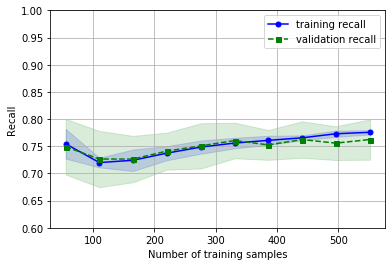

In [7]:
#Plot Learning Curve
print('LDA Learning Curve')
plot_learning_curves(pipe_lda)

Model Evaluation - Recall Score
LDA 0.77 +/- 0.05




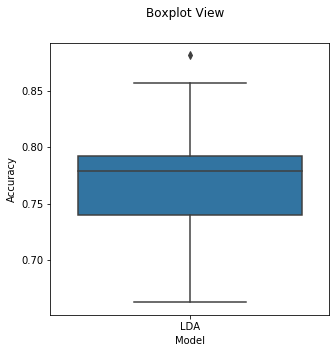

In [8]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('LDA',pipe_lda))

#Model Evaluation
results =[]
names=[]
scoring ='recall_weighted'
print('Model Evaluation - Recall Score')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x,Y,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n')

#Boxplot View
fig = plt.figure(figsize=(5,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()

In [9]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, n_jobs=1, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train_smt, y_train_smt)
    model = gs_clf.best_estimator_    
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Identify Features
    feature_names = list(dataset.drop('Outcome', axis=1))
    feature_importance = list(zip(feature_names, gs_clf.best_estimator_.named_steps['rfe'].support_))

    new_features = []

    for key,value in enumerate(feature_importance):
         if(value[1]) == True:
                new_features.append(value[0])
    
    #Output Validation Statistics
    target_names=['Outcome 0','Outcome 1']
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
    print('\nBest Parameters:',bestpara)
    print('\nKey Features:',new_features)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 

In [10]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)


Optimized Model

Model Name: LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

Best Parameters: {'rfe__estimator__solver': 'svd'}

Key Features: ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction']

 [[80 20]
 [14 40]]

               precision    recall  f1-score   support

   Outcome 0       0.85      0.80      0.82       100
   Outcome 1       0.67      0.74      0.70        54

    accuracy                           0.78       154
   macro avg       0.76      0.77      0.76       154
weighted avg       0.79      0.78      0.78       154

